### リカレントニューラルネットワークの高度な使い方

気温、気圧、湿度といった時系列データから２４時間後の気温を予測する。<br>
これは難易度の高い問題であり、時系列データを扱うときに苦労する部分が実際に明らかになる。<br>

### ここで取り上げる方法

<ul>
    <li>リカレントドロップアウト : リカレント層でドロップアウトを使って過学習に対抗。</li>
    <li>リカレント層のスタッキング : ネットワークの表現力を高める。</li>
    <li>双方向のリカレント層 : 同じ情報をさまざまな方法でRNNに提供し、正解率を向上させ、忘却の問題に対処。</li>
</ul>

### 気温予測問題

データセットは、14種類の数値（気温、気圧、湿度、風向など）を１０分おきに記録した数年分のデータセットで構成されている。<br>
このデータセットを使用して、最近のデータを入力として受け取り、２４時間後の気温を予測する。<br>

### データの調査

In [1]:
# 気象データセットの調査
import os

data_dir = '/Users/Takanori/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [2]:
# Pandasで表示してみる
import pandas as pd
df = pd.read_csv(fname)

In [3]:
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
# ファイルの読み込み
f = open(fname)
data = f.read()
f.close()

In [5]:
# 読み込んだファイルの確認
data[:200]

'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"\n01.0'

In [6]:
# 改行で配列を作成
lines = data.split('\n')
print(len(lines))
print(len(lines[0]))
print(lines[0])

420552
195
"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"


In [7]:
# 見出しの配列の作成
header = lines[0].split(',')
lines = lines[1:]

In [8]:
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [9]:
# データをNumpy配列に変換
import numpy as np

# 日付を抜いている
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, : ] = values

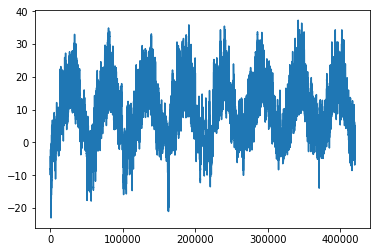

In [10]:
# 気温の時系列データのプロット
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

このデータは10分おきに記録されるため、1日あたりのデータ点は144個。<br>

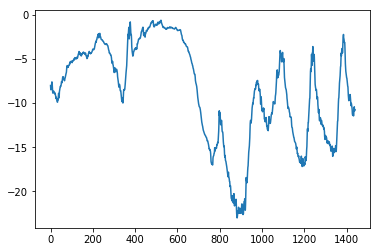

In [11]:
# 最初の10日間の気温データのプロット
plt.plot(range(1440), temp[:1440])
plt.show()

## データの準備

この問題を定式化すると以下のようになる。<br>
lookback時間刻みに遡るデータが存在し、steps時間刻みごとにサンプリング、delay時間刻みの気温を予測。<br>
lookback = 720　…　過去５日分の観測データ<br>
steps = 6 …　観測データは１時間あたり１データ点の割合で観測<br>
delay = 144　… 目的地は24時間後の気温<br>

### データの前処理を行い、ニューラルネットワークに読み込めるフォーマットにする

<ol>
    <li>各時系列を個別に正規化。</li>
    <li>Pythonジェネレータの記述 : 最近のデータと目的値（将来の気温）からなるバッチを生成。<br>
         サンプル$N$とサンプル$N+1$の時間刻みは、ほとんど共通。<br>
        そこで、元のデータを使ってサンプルをその場で生成。<br>
    </li>
</ol>

#### データの正規化

In [12]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

#### データジェネレータ

ジェネレータが生成するのはタプル（samples, targets）である。<br>
ジェネレータは以下の8つの引数を受け取る。<br>

<ul>
    <li>data : 元の浮動小数点型のデータからなる配列</li>
    <li>lookback : 入力データの時間刻みをいくつか遡る。</li>
    <li>delay : 目的値の時間刻みをいくつか進める。</li>
    <li>min_index, max_index : データの一部を検証とテストのために取っておくのに役立つ。</li>
    <li>shuffle : サンプルをシャッフルするのか、それとも時間順序で抽出するのか。</li>
    <li>batch_size : バッチ１つあたりのサンプル数。</li>
    <li>step : データをサンプリングするときの期間。データ点を1時間ごとに１つ抽出するために6に設定</li>
</ul>

In [61]:
# 時系列サンプルとそれらの目的値を生成するジェネレータ
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [62]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

# 訓練ジェネレータ
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

# 検証ジェネレータ
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

# テストジェネレータ
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 検証データセット全体を調べるためにval_genから抽出する時間刻みの数
val_steps = (300000 - 200001 - lookback) // batch_size

# テストデータセット全体を調べるためにtest_genから抽出する時間刻みの数
test_steps = (len(float_data) - 300001 - lookback) // batch_size

#### 機械学習とは別の、常識的なベースライン

クラスA、クラスBが存在しクラスAが90%を占めていた場合、<br>
クラスAと判断すると正解率は90%。<br>
この場合も同様に、常識的なアプローチでは、常に、２４時間後の気温が現在と同じになると予測。<br>

In [63]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [64]:
evaluate_naive_method()

0.2897359729905486


In [65]:
celsius_mae = 0.29 * std[1]

In [66]:
# 平均絶対誤差
celsius_mae

2.5672247338393395

#### 機械学習の基本的なアプローチ

RNNなどの複雑で計算負荷の高い機械学習モデルを調べる前には、<br>
その前に、単純で計算負荷の低いモデルを試してみる。<br>

In [67]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 13s 25ms/step - loss: 1.1292 - val_loss: 0.5094
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.4112 - val_loss: 0.3316
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2947 - val_loss: 0.3071
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2671 - val_loss: 0.3029
Epoch 5/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2534 - val_loss: 0.3346
Epoch 6/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2441 - val_loss: 0.3060
Epoch 7/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2370 - val_loss: 0.3092
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2306 - val_loss: 0.3664
Epoch 9/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2245 - val_loss: 0.3123
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.222

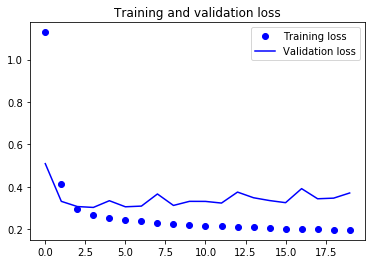

In [68]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### GRUを用いたリカレントベースライン

In [77]:
# GRUベースのモデルの訓練と評価
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data = val_gen,
    validation_steps = val_steps
)

Epoch 1/20
500/500 [==============================] - 104s 207ms/step - loss: 0.3128 - val_loss: 0.2739
Epoch 2/20
500/500 [==============================] - 97s 195ms/step - loss: 0.2846 - val_loss: 0.2713
Epoch 3/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2787 - val_loss: 0.2645
Epoch 4/20
500/500 [==============================] - 98s 196ms/step - loss: 0.2722 - val_loss: 0.2715
Epoch 5/20
500/500 [==============================] - 106s 212ms/step - loss: 0.2681 - val_loss: 0.2640
Epoch 6/20
500/500 [==============================] - 110s 220ms/step - loss: 0.2633 - val_loss: 0.2647
Epoch 7/20
500/500 [==============================] - 102s 204ms/step - loss: 0.2581 - val_loss: 0.2664
Epoch 8/20
500/500 [==============================] - 100s 199ms/step - loss: 0.2552 - val_loss: 0.2689
Epoch 9/20
500/500 [==============================] - 100s 199ms/step - loss: 0.2521 - val_loss: 0.2778
Epoch 10/20
500/500 [==============================] - 100s 200ms/

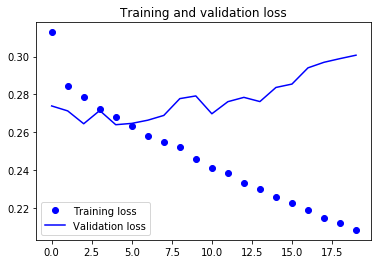

In [78]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()